# Librerías

In [ ]:
import os
import sys

import numpy as np
import pandas as pd 
import random
from glob import glob
import re
from scipy import interp  
from itertools import cycle


import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
%matplotlib inline
import cv2


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize, OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report 
from sklearn.datasets import make_classification  

import tensorflow as tf

from keras.utils import layer_utils, np_utils
from keras.preprocessing.image import ImageDataGenerator  
from keras.applications import densenet, vgg16, nasnet, vgg19  
from keras.models import Sequential, Model, load_model  
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.optimizers import SGD
from keras import regularizers  
from keras import backend as K 

import pickle

# Importar imágenes

## Funciones

In [129]:
def open_images_names(directory):
    
    """
    **************************************************************
    
    Abre las imagenes de un directorio y las almacena en un array.
    Extrae el nombre del artista del path de la imagen.
    
    Input:
    *directory. Path en el que se encuentran las imágenes.
    Output:
    *np.array con la información de las imágenes
    *np.array con el nombre del artista.
    
    ***************************************************************
    """
    
    images_all = []
    images = glob(directory)
    i_ = 0
    
    for img in images:
        im = cv2.imread(img)
        images_all.append(np.asarray(im))
        i_ += 1
    
    artists = []
    for artist in images:
        art = re.sub("_", " ", (",").join(re.findall("\w+_", artist))[:-1])
        artists.append(art)

        
    return images_all, artists

In [130]:
def muestra(bd): 
    
    """
    **************************************************************
    
    Muestra de forma aleatoria una de las imágenes importadas junto
    con información de su tamaño y autor.
    
    ***************************************************************
    """
    
    plt.rcParams['figure.figsize'] = (8, 15) 
    
    num = random.randrange(len(images))
    print(f'Autor: {artists[num]}')
    print(f'Dimensión:{bd[num].shape}')
    print(f'Alto: {bd[num].shape[0]} px.')
    print(f'Ancho: {bd[num].shape[1]} px.')
    print(f'Profundidad: {bd[num].shape[2]} (RGB)')

    plt.imshow(cv2.cvtColor(bd[num], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## Proceso

Aplicando la función <code>open_images_names</code> obtendremos las imágenes a analizar junto con una lista con los nombres que se extraen del archivo, lo unico que tenemos que pasarle a la función es la dirección del directorio donde están nuestras imagenes junto con <k>/**</k> para que nos extraiga todos los archivos que hay dentro.

In [131]:
images, artists = open_images_names("images/**")

Echaremos un primer vistazo a la estructura que tiene nuestros inputs.

In [132]:
print(f'Disponemos de un total de {len(images)} imagenes con {len(pd.unique(artists))} artistas diferentes, entre los que encontramos a {pd.unique(artists)[random.randrange(len(pd.unique(artists)))]}, {pd.unique(artists)[random.randrange(len(pd.unique(artists)))]} o {pd.unique(artists)[random.randrange(len(pd.unique(artists)))]}.')

Disponemos de un total de 8683 imagenes con 50 artistas diferentes, entre los que encontramos a Pieter Bruegel, Edgar Degas o El Greco.


Con la función <code>muestra</code> podemos ver imágenes de nuestra colección junto con el nombre del artista y el tamaño. Cada vez que se ejecute saldrá una diferente.

Autor: Edgar Degas
Dimensión:(439, 577, 3)
Alto: 439 px.
Ancho: 577 px.
Profundidad: 3 (RGB)


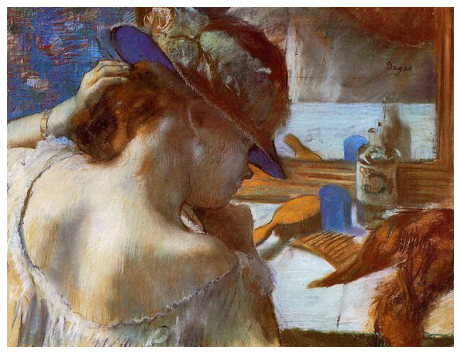

In [133]:
muestra(images)

# Corregir problemas de balanceo

## Funciones

In [134]:
def top_artists(df, y, num):
    
    """
    **************************************************************
    
    Divide la información en dos datasets diferentes usando la media
    del total de observaciones por categorías como separación.
    
    Input:
    df: dataframe a separar.
    y: variable dependiente.
    
    Output:
    *big_df: dataframe con las categorías con más observaciones.
    *small_df: dataframe con las categorías con menos observaciones.
    
    ***************************************************************
    """
    
    # Crea dos listas, una con las etiquetas de categoría con más observaciones
    # observaciones y la otra con las que tienen menos.
    
    c = list(df['artist'].value_counts()[0:num].index)
            
    # Crea los dos dataframes tomando el original y agrupando según las categorías
    # listadas en el paso anterior
            
    big_df = []
    for i in c:
        big_df.extend(np.array(df[df[y] == i]))
    big_df = pd.DataFrame(big_df, columns = df.columns)

            
    return big_df

In [143]:
def visualice(df_big, df_small):
    
    """
    **************************************************************
    
    Muestra dos barplots con los artistas que se han separado.
    
    Input:
    df_big: dataframe con los artistas con más cuadros.
    df_small: dataframe con los artistas con menos cuadros.
    
    Output:
    * Barplots con ambas distribuciones
    
    ***************************************************************
    """

    print(f' Hay {len(pd.unique(df_big["artist"]))} artistas con más de {df_big["artist"].value_counts()[-1]} obras y {len(pd.unique(df_small["artist"]))} con menos.')
          
    fig = plt.figure(figsize=(15,5))

    fig.add_subplot(121)
    plt.title('Dataset original', fontsize=14)
    artists_plot1 = sns.countplot(df_big['artist'], palette="ch:.25")
    _=artists_plot1.set_xticklabels(artists_plot1.get_xticklabels(), rotation=65, horizontalalignment='right')
    fig.add_subplot(122)
    
    plt.title('Aristas con más obras obras', fontsize=14)
    artists_plot2 = sns.countplot(df_small['artist'], palette="ch:.25")
    _=artists_plot2.set_xticklabels(artists_plot2.get_xticklabels(), rotation=65, horizontalalignment='right')

In [144]:
def countplot_df(df, col):
    """
    **************************************************************
    Devuelve un gráfico de barras con los parámetros de visualización
    indicados
    Input:
    *df: dataframe del que extraer la información
    *col: columna que se quiere contar.
    **************************************************************
    
    """
    
    plt.rcParams['figure.figsize'] = (15, 8) 
    plot_df = sns.countplot(df[col], palette="ch:.25")
    _ = plot_df.set_xticklabels(plot_df.get_xticklabels(), rotation=65, horizontalalignment='right')

## Proceso

Generaremos una estructura de DataFrame para poder corregir los problemas de desbalanceo que hemos visto. Hacemos el cambio de estructura desde nuestras imágenes.

In [137]:
df = pd.DataFrame(images, columns = ['images'])

Añadimos la columna con los nombres de los artistas.

In [138]:
df['artist'] = artists

Echamos un vistazo al DataFrame creado para ver la estructura que sigue

In [139]:
df.head()

,images,artist
0,"[[[87, 99, 101], [43, 55, 57], [33, 42, 45], [...",Pieter Bruegel
1,"[[[84, 136, 149], [88, 140, 153], [87, 139, 15...",Francisco Goya
2,"[[[68, 80, 92], [63, 75, 87], [58, 70, 82], [5...",Paul Cezanne
3,"[[[122, 156, 186], [120, 154, 184], [109, 143,...",Vincent van Gogh
4,"[[[5, 6, 4], [0, 0, 0], [0, 2, 1], [0, 1, 0], ...",Titian


Podemos observar como disponemos de más de 800 cuadros de Van Gogh, frente a los sobre 50 de Cezanne. Hay diferentes estrategias que podemos seguir llegados a este punto:
* Empezaremos probando con una selección de artistas que tengan el número de obras más balanceadas.

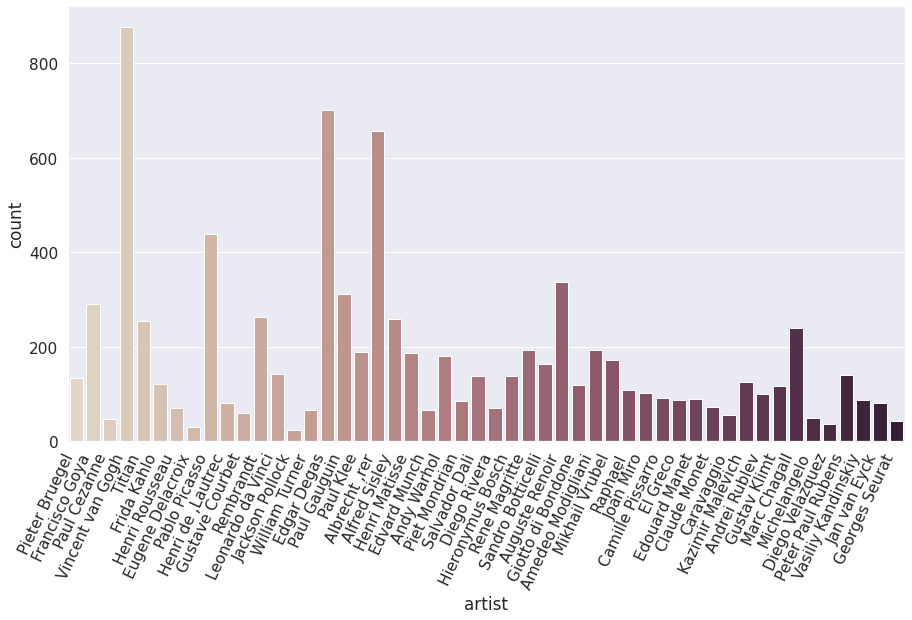

In [140]:
countplot_df(df, 'artist')

Usaremos la función <code>subsample_mean</code> que hemos creado para dividir el dataset en dos y quedarnos solo con los cuadros de los artistas que tengamos más cantidad de información que la media.

In [153]:
version1 = top_artists(df, 'artist', 10)

Dataset original vs dataset con la selección.
 Hay 50 artistas con más de 24 obras y 10 con menos.


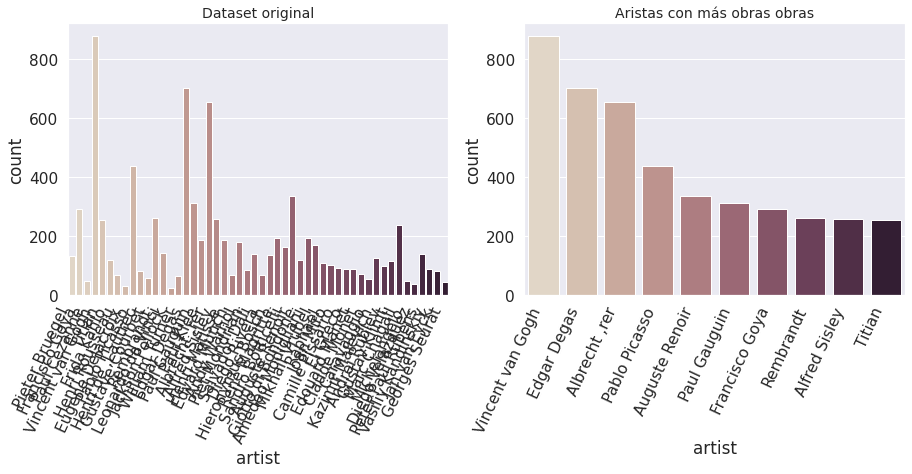

In [145]:
print("Dataset original vs dataset con la selección.")
visualice(df, version1)

In [146]:
version1.head()

,images,artist
0,"[[[122, 156, 186], [120, 154, 184], [109, 143,...",Vincent van Gogh
1,"[[[230, 218, 116], [217, 208, 104], [218, 212,...",Vincent van Gogh
2,"[[[175, 225, 231], [191, 240, 248], [180, 230,...",Vincent van Gogh
3,"[[[42, 147, 198], [82, 187, 238], [100, 208, 2...",Vincent van Gogh
4,"[[[37, 87, 105], [47, 99, 116], [97, 147, 169]...",Vincent van Gogh


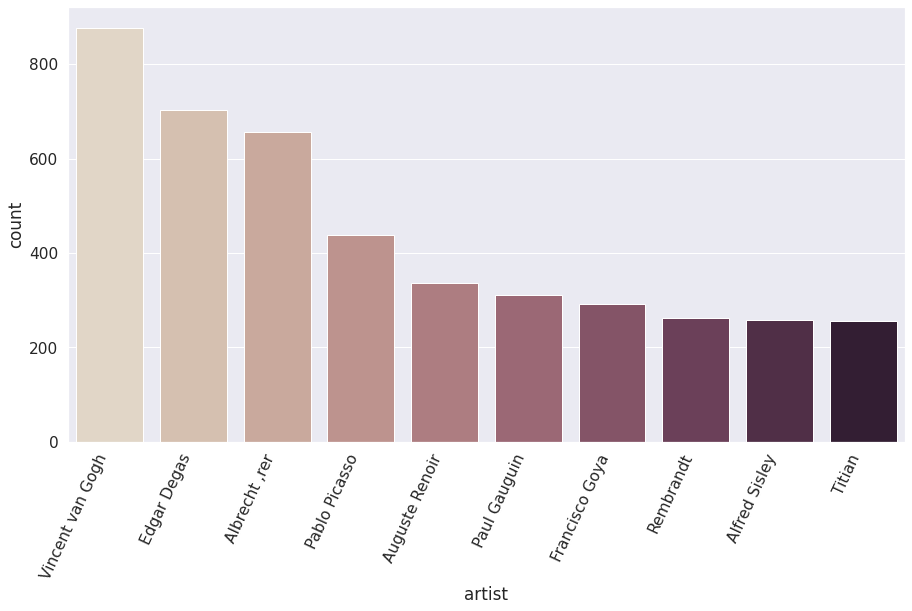

In [147]:
countplot_df(version1, 'artist')

# Separar train/test

In [154]:
images_v1=np.asarray(version1['images'])
artists =version1['artist']

In [155]:
num_classes = len(pd.unique(artists))

In [156]:
le=LabelEncoder()
le_artists = le.fit_transform(artists)
artists_dict = {}
for i in range(0, len(artists)):
    artists_dict[le_artists[i]]=artists[i]

In [157]:
artists_dict

{9: 'Vincent van Gogh',
 3: 'Edgar Degas',
 0: 'Albrecht ,rer',
 5: 'Pablo Picasso',
 2: 'Auguste Renoir',
 6: 'Paul Gauguin',
 4: 'Francisco Goya',
 7: 'Rembrandt',
 1: 'Alfred Sisley',
 8: 'Titian'}

In [158]:
x_train_original, x_test_original, y_train_original, y_test_original = train_test_split(images_v1, le_artists, test_size=0.2, random_state=42)

In [159]:
#Esto convierte a OneHotEncoding

y_train = np.array(np_utils.to_categorical(y_train_original, num_classes))
#y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_test = np_utils.to_categorical(y_test_original, num_classes)
#y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

# Ajustar el tamaño de las imágenes

## Funciones

In [160]:
def resize_data(data):  
    
    """
    **************************************************************
    
    Ajusta el tamaño de la imágen para su estandarización.
    
    ***************************************************************
    """
    
        
    res_data = []
    for i in range(len(data)):
        res = cv2.resize(data[i], dim, interpolation=cv2.INTER_LINEAR)
        res_data.append(res)

    return res_data

In [161]:
def compara_muestras(db1, db2):
        
    """
    **************************************************************
    
    Muestra de forma aleatoria una de las imágenes importadas junto
    con información de su tamaño y autor.
    
    ***************************************************************
    """
    
    plt.rcParams['figure.figsize'] = (15, 8) 
    
    num = random.randrange(len(db1))
    
    print(f'Autor: {artists[num]}')
    print(f'Dimensión original:{db1[num].shape}')
    print(f'Dimensión ajustada:{db2[num].shape}')
    print(f'Filas originales: {db1[num].shape[0]}')
    print(f'Filas ajustadas: {db2[num].shape[0]}')
    print(f'Columnas originales: {db1[num].shape[1]}')
    print(f'Columnas ajustadas: {db2[num].shape[1]}')
    print(f'Profundidad: {db1[num].shape[2]}')
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Imagen original vs imagen ajustada')

    ax1.imshow(cv2.cvtColor(db1[num], cv2.COLOR_BGR2RGB))
    ax1.axis('off')
    ax1.set_title("Imagen original")
    ax2.imshow(cv2.cvtColor(db2[num], cv2.COLOR_BGR2RGB))
    ax2.axis('off')
    ax2.set_title("Imagen ajustada")
    plt.show()

## Proceso

Las imágenes que forman nuestra clección tienen diferentes tamaños, deberemos establecer un tamaño común para todas para poder entrenar nuestro algoritmo.

In [162]:
dim = (150, 150)

In [163]:
x_train = resize_data(x_train_original)
x_train = np.asarray(x_train)

In [164]:
x_test = resize_data(x_test_original)
x_test = np.asarray(x_test)

Comparamos la imagen original con el ajuste.

Autor: Paul Gauguin
Dimensión original:(461, 307, 3)
Dimensión ajustada:(150, 150, 3)
Filas originales: 461
Filas ajustadas: 150
Columnas originales: 307
Columnas ajustadas: 150
Profundidad: 3


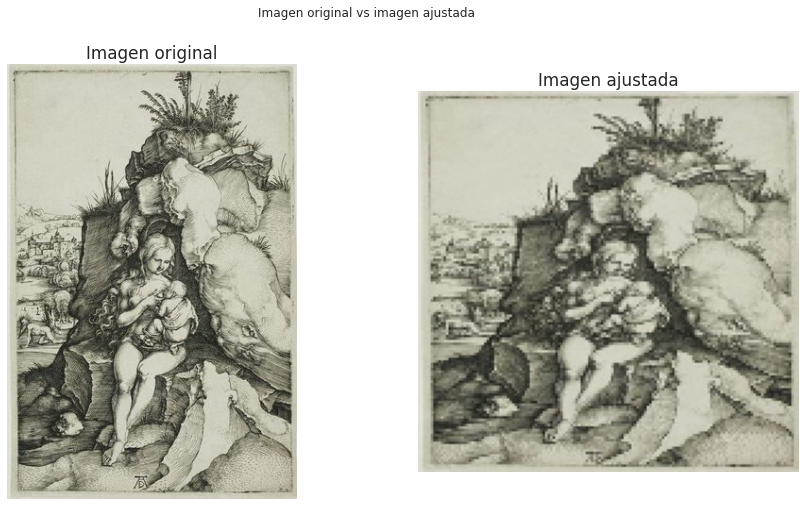

In [165]:
compara_muestras(x_train_original, x_train)

# DataAugmentation

Establecemos los parametros para la creación de nuevas imagenes

# Empecemos

## Algunas consideraciones previas

Antes de ponernos a probar modelos estableceremos nuestros objetivos en los resultados. Para ello definiremos las métricas que nos indicarán si nuestro modelo está haciendo bien el trabajo. Empezamos por definir los indicadores:


**Métricas de evaluación del modelo**:

* **loss**: Por lo general, con las redes neuronales, buscamos minimizar el error. Como tal, la función objetivo a menudo se denomina función de costo o función de pérdida y el valor calculado por la función de pérdida.
* **mse**: El *error cuadrático medio* (median standard error)es una función de coste se pueden utilizar métodos estadísticos formales para determinar la confianza del modelo entrenado. 

* **acurracy**: 
* **precision**:
* **recall**:
* **f1**:

**Hiperparametros a tener en cuenta**:

* **Batch**: Con el *bach* definimos el número de muestras para trabajar antes de actualizar los paramétros internos del modelo. Las predicciones se comparan con las variables de salidad esperadas y se calcula el error. A partir de este error el algoritmo se actualiza para mejorarse.

    * **Batch Gradient Descent**. Cuando el tamaño del bach es igual que el del conjunto de entrenamiento
    * **Stochastic Gradient Descent**. Cuando el tamaño del bach es igual a 1.
    * **Mini-Batch Gradient Descent**. Cuando el tamaño del bach está entre uno y el tamaño del conjunto de entrenamient, los más frecuentes en tutoriales son de  32, 64 y 128.
    
    
* **Epoch**: Se trata de un hiperparámetro que define el número de veces que el algoritmo de aprendizaje funcionará sobre el conjunto de datos de entrenamiento. Cada muestra del conjunto de datos de entrenamiento tiene la "oportunidad" de actualizar los parámetros internos del modelo. Puede estar compuesto por uno o más *batches*. El número de *epochs* suele ser grande, lo que permite que el algoritmo se ejecute hasta que el error del modelo se minimice lo suficiente.

## Funciones

In [166]:
def conf_matrix(num_classes, model_pred):
    
    """
    **************************************************************
    
    Crea una matriz de confusión del modelo.

    ***************************************************************
    """
    
    #Creamos la matriz de confusión
    model_cm = confusion_matrix(np.argmax(y_test, axis=1), model_pred)

    # Visualizamos la matriz de confusión
    model_df_cm = pd.DataFrame(model_cm, range(num_classes), range(num_classes))  
    plt.figure(figsize = (20,14))  
    sns.set(font_scale=1.4) #for label size  
    sns.heatmap(model_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    plt.show() 

In [167]:
def plot_train_vs_test (model):
    
    """
    **************************************************************
    
    Visualiza en forma de gráfico las curvas del accuracy y del loss
    entre el train y el test.

    ***************************************************************
    """
    
    plt.rcParams['figure.figsize'] = (8, 6) 
    
    plt.figure(0)  
    plt.plot(model.history['acc'],'r')  
    plt.plot(model.history['val_acc'],'g')  
    plt.xticks(np.arange(0, 11, 2.0))   
    plt.xlabel("Num of Epochs")  
    plt.ylabel("Accuracy")  
    plt.title("Training Accuracy vs Validation Accuracy")  
    plt.legend(['train','validation'])

    plt.figure(1)  
    plt.plot(model.history['loss'],'r')  
    plt.plot(model.history['val_loss'],'g')  
    plt.xticks(np.arange(0, 11, 2.0))   
    plt.xlabel("Num of Epochs")  
    plt.ylabel("Loss")  
    plt.title("Training Loss vs Validation Loss")  
    plt.legend(['train','validation'])

    plt.show()

In [168]:
def plot_roc(model_pred):
    
    """
    **************************************************************
    
    
    
    ***************************************************************
    """

    # Plot linewidth.
    lw = 2

    # Compute ROC curve and ROC area for each class
    fpr = dict()  
    tpr = dict()  
    roc_auc = dict()  
    for i in range(num_classes):  
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], model_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), model_pred.ravel())  
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)  
    for i in range(num_classes):  
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= num_classes

    fpr["macro"] = all_fpr  
    tpr["macro"] = mean_tpr  
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)  
    plt.plot(fpr["micro"], tpr["micro"],  
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],  
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])  
    for i, color in zip(range(3), colors):  
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
    plt.xlim([0.0, 1.0])  
    plt.ylim([0.0, 1.05])  
    plt.xlabel('False Positive Rate')  
    plt.ylabel('True Positive Rate')  
    plt.title('Some extension of Receiver operating characteristic to multi-class')  
    plt.legend(loc="lower right")  
    plt.show()


    # Zoom in view of the upper left corner.
    plt.figure(2)  
    plt.xlim(0, 0.2)  
    plt.ylim(0.8, 1)  
    plt.plot(fpr["micro"], tpr["micro"],  
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],  
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])  
    for i, color in zip(range(3), colors):  
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
    plt.xlabel('False Positive Rate')  
    plt.ylabel('True Positive Rate')  
    plt.title('Some extension of Receiver operating characteristic to multi-class')  
    plt.legend(loc="lower right")  
    plt.show() 

In [42]:
K.set_image_data_format('channels_last')  

In [43]:
K.set_learning_phase(1) 

# Red Neuronal Simple

Empezaremos definiendo una red neuronal simple y junto con ella, algunos conceptos que se irán repitiendo a medida que vayamos viendo diferentes modelos:
* **Flatten**: Convierte la matriz de entrada en un array de 1 dimensión, en un array plano.
+ **Dense**: Añade una capa oculta la red neuronal.

**Función de activación ReLu**: Transforma los valores introducidos anulando los valores negativos y dejando los positivos tal y como entran. La ventaja de usar la función ReLU radica en que no posee regiones de saturación dado que tiene un comportamiento lineal para entradas positivas, lo que evita precisamente este "estancamiento" durante el entrenamiento.

**Función de salida SoftMax**: Asigna probabilidades decimales a cada clase en un caso de clases múltiples. Esas probabilidades decimales deben sumar 1.0. Esta restricción adicional permite que el entrenamiento converja más rápido.

In [94]:
def create_simple_nn(): 
    
    model = Sequential()
    model.add(Flatten(input_shape=x_train[0].shape, name="Input_layer"))
    model.add(Dense(30000, activation='relu', name="Hidden_layer_1"))
    model.add(Dense(15000, activation='relu', name="Hidden_layer_2"))
    model.add(Dense(7000, activation='relu', name="Hidden_layer_3"))
    model.add(Dense(3000, activation='relu', name="Hidden_layer_4"))
    model.add(Dense(1000, activation='relu', name="Hidden_layer_5"))
    model.add(Dense(500, activation='relu', name="Hidden_layer_6"))
    model.add(Dense(100, activation='relu', name="Hidden_layer_7"))
    model.add(Dense(num_classes, activation='softmax', name="Output_layer"))

    return model

In [95]:
snn_model = create_simple_nn()  

Definimos nuestra función de pérdida en <code>loss</code> entre las opciones:
* <code>'categorical_crossentropy'</code> : Calcula la pérdida de crossentropy entre los artistas y las predicciones. Se usa cuando hay dos o más etiquetas. Necesita de una representación <code>OneHotEncoding</code>.
* <code>'sparse_categorical_crossentropy'</code> : Calcula la pérdida de crossentropy entre los artistas y las predicciones. Se usa cuando hay dos o más etiquetas. Necesita de una representación <code>LabelEncoder</code>.

Para nuestro <code>optimizer</code> usaremos:
* <code>'Adam'</code>: implementa el algoritmo Adam. Se trata de un método de descenso de gradiente estocástico que se basa en la estimación adaptativa. Se trara de un método computacionalmente eficiente y con pocos requisitos de memoria y adecuado para problemas con grandes cantidades de datos/parámetros.

En cuanto a nuestras métricas, en <code>metrics</code>

In [96]:
snn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])

In [97]:
snn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (Flatten)        (None, 67500)             0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 100)               6750100   
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 50)                5050      
_________________________________________________________________
Output_layer (Dense)         (None, 10)                510       
Total params: 6,755,660
Trainable params: 6,755,660
Non-trainable params: 0
_________________________________________________________________


In [103]:
snn = snn_model.fit(x=x_train, y=y_train, batch_size=32, epochs=15, verbose=1, validation_data=(x_test, y_test), shuffle=True)   

Train on 3510 samples, validate on 878 samples
Epoch 1/2
3510/3510 [==============================] - 7s 2ms/step - loss: 2.2015 - acc: 0.1952 - mse: 0.0878 - val_loss: 2.1686 - val_acc: 0.2187 - val_mse: 0.0870
Epoch 2/2
3510/3510 [==============================] - 7s 2ms/step - loss: 2.2015 - acc: 0.1952 - mse: 0.0878 - val_loss: 2.1685 - val_acc: 0.2187 - val_mse: 0.0870


In [104]:
evaluation = snn_model.evaluate(x=x_test, y=y_test, batch_size=32, verbose=1)  
evaluation

878/878 [==============================] - 1s 822us/step


[2.1685202871205322, 0.218678817152977, 0.08704245090484619]

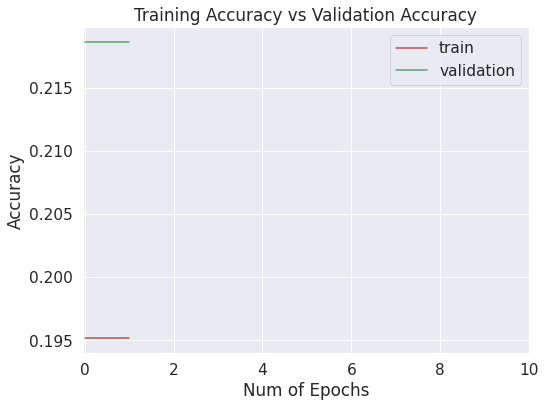

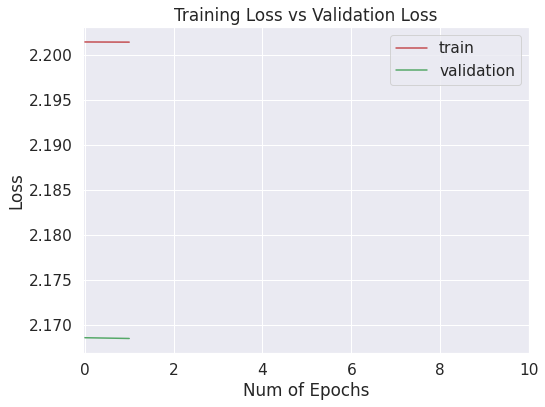

In [105]:
plot_train_vs_test(snn)

In [107]:
snn_pred = snn_model.predict(x_test, batch_size=32, verbose=1)  
snn_predicted = np.argmax(snn_pred, axis=1) 

878/878 [==============================] - 1s 714us/step


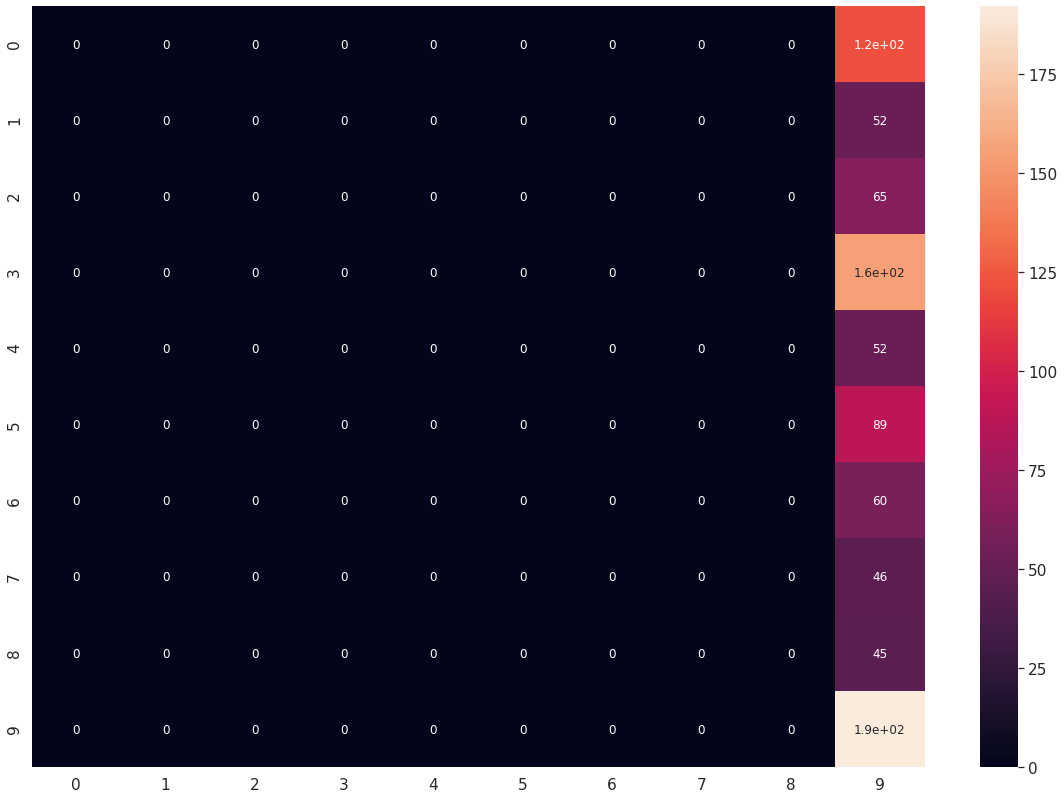

In [108]:
conf_matrix(num_classes, snn_predicted)

In [109]:
snn_report = classification_report(np.argmax(y_test, axis=1), snn_predicted)  
print(snn_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       122
           1       0.00      0.00      0.00        52
           2       0.00      0.00      0.00        65
           3       0.00      0.00      0.00       155
           4       0.00      0.00      0.00        52
           5       0.00      0.00      0.00        89
           6       0.00      0.00      0.00        60
           7       0.00      0.00      0.00        46
           8       0.00      0.00      0.00        45
           9       0.22      1.00      0.36       192

    accuracy                           0.22       878
   macro avg       0.02      0.10      0.04       878
weighted avg       0.05      0.22      0.08       878



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


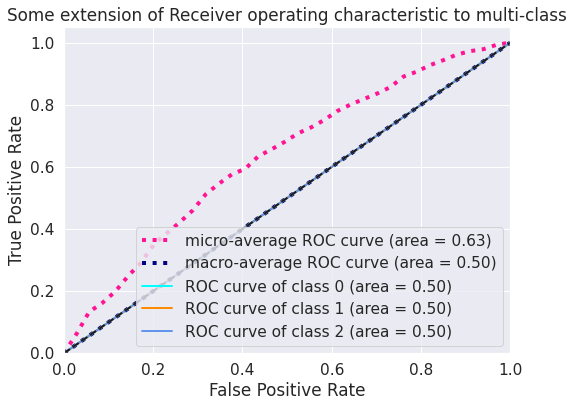

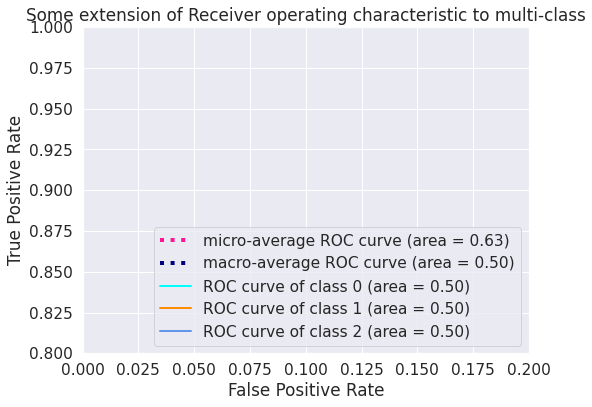

In [56]:
plot_roc(snn_pred)

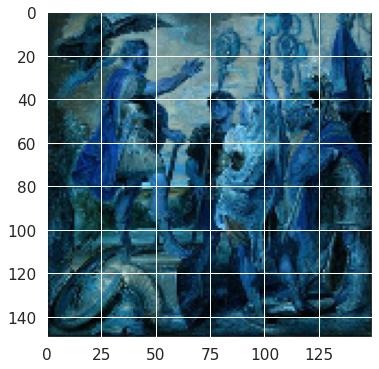

class for image 1: 13
predicted:         24


In [57]:
imgplot = plt.imshow(x_train[0],cv2.COLOR_BGR2RGB))  
plt.show()  
print('class for image 1: ' + str(np.argmax(y_test[0])))  
print('predicted:         ' + str(snn_predicted[0]))  

In [58]:
#Histórico
with open('simplenn_history.txt', 'wb') as file_pi:  
  pickle.dump(snn.history, file_pi)

# Convultional Nets

In [2]:
def create_simple_cnn(): 
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), input_shape=x_train[0].shape, activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))

    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [3]:
scnn_model = create_simple_cnn()  
scnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse']) 

NameError: name 'Sequential' is not defined

In [124]:
scnn_model.summary() 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_831 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_832 (Conv2D)          (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_833 (Conv2D)          (None, 71, 71, 128)       73856     
_________________________________________________________________
conv2d_834 (Conv2D)          (None, 69, 69, 256)       295168    
_________________________________________________________________
conv2d_835 (Conv2D)          (None, 67, 67, 512)       1180160   
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 33, 33, 512)      

In [121]:
scnn = scnn_model.fit(x_train, y_train, batch_size=32, epochs=5, verbose=1, validation_data=(x_test, y_test), shuffle=True)

ValueError: Error when checking target: expected dense_9 to have 4 dimensions, but got array with shape (3510, 10)

In [ ]:
cnn_evaluation = scnn_model.evaluate(x=x_test_resized, y=y_test, batch_size=32, verbose=1)  
cnn_evaluation  

In [ ]:
plot_train_vs_test(scnn)

In [ ]:
scnn_pred = scnn_model.predict(x_test_resized, batch_size=32, verbose=1)  
scnn_predicted = np.argmax(scnn_pred, axis=1)

In [ ]:
#Creamos la matriz de confusión
scnn_cm = confusion_matrix(np.argmax(y_test, axis=1), scnn_predicted)

# Visualiamos la matriz de confusión
scnn_df_cm = pd.DataFrame(scnn_cm, range(50), range(50))  
plt.figure(figsize = (20,14))  
sns.set(font_scale=1.4) #for label size  
sns.heatmap(scnn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
scnn_report = classification_report(np.argmax(y_test, axis=1), scnn_predicted)  
print(scnn_report) 

In [ ]:
plot_roc(scnn_pred)

In [ ]:
imgplot = plt.imshow(x_train_original[5])  
plt.show()  
print('class for image 1: ' + str(np.argmax(y_test[5])))  
print('predicted:         ' + str(scnn_predicted[5])) 

In [ ]:
#Histórico
with open('scnn_history.txt', 'wb') as file_pi:  
  pickle.dump(scnn.history, file_pi)

# VGG-16 (hay una 19 y una bis)

Seguimos los mismos casos que con los modelos anteriores. Para este caso tendremos en cuenta los siguientes parámetros:
* **include_top**: añade una red neuronal densa al final.
* **weights**: no cargaremos ningún modelo entrenado previamente como si haremos más adelante.
* **input_tensor**:no especificaremos ningún tensor de keras.
* **input_shape**:define la dimensión de los datos de entrada.
* **pooling**: no lo especificamos.
* **classes**: le indicamos el número de clases.

In [185]:
def create_vgg16():  
  model = vgg16.VGG16(include_top=True, weights=None, input_tensor=None, input_shape=x_train[0].shape, pooling=None, classes=num_classes)

  return model

In [186]:
vgg16_model = create_vgg16()  
vgg16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse']) 

Echamos un vistazo al modelo que hemos creado

In [187]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Tenemos más de 65 millones de parámetros para entrenar. Frente a los 6 millones de nuestra red neuronal simple o los 120 de la red convolucional.

In [190]:
vgg16 = vgg16_model.fit(x_train, y_train, batch_size=32, epochs=5, verbose=1, validation_data=(x_test, y_test), shuffle=True) 

Train on 3510 samples, validate on 878 samples
Epoch 1/5
3510/3510 [==============================] - 856s 244ms/step - loss: 2.1667 - acc: 0.2123 - mse: 0.0870 - val_loss: 2.0833 - val_acc: 0.2198 - val_mse: 0.0846
Epoch 2/5
3510/3510 [==============================] - 844s 241ms/step - loss: 2.1485 - acc: 0.2245 - mse: 0.0868 - val_loss: 2.0247 - val_acc: 0.2699 - val_mse: 0.0838
Epoch 3/5
3510/3510 [==============================] - 845s 241ms/step - loss: 2.0652 - acc: 0.2843 - mse: 0.0845 - val_loss: 2.2126 - val_acc: 0.2608 - val_mse: 0.0880
Epoch 4/5
3510/3510 [==============================] - 850s 242ms/step - loss: 1.9682 - acc: 0.3091 - mse: 0.0825 - val_loss: 2.0168 - val_acc: 0.2802 - val_mse: 0.0831
Epoch 5/5
3510/3510 [==============================] - 849s 242ms/step - loss: 1.8970 - acc: 0.3405 - mse: 0.0805 - val_loss: 1.6753 - val_acc: 0.4043 - val_mse: 0.0739


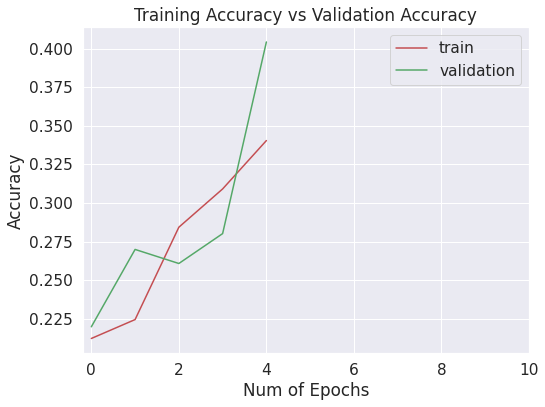

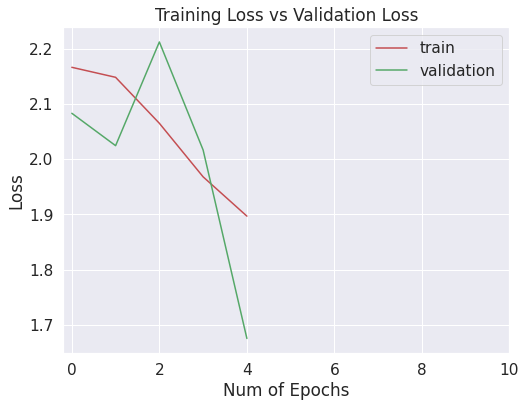

In [192]:
plot_train_vs_test(vgg16)

In [194]:
vgg16_pred = vgg16_model.predict(x_test, batch_size=32, verbose=1)  
vgg16_predicted = np.argmax(vgg16_pred, axis=1)  

878/878 [==============================] - 48s 55ms/step


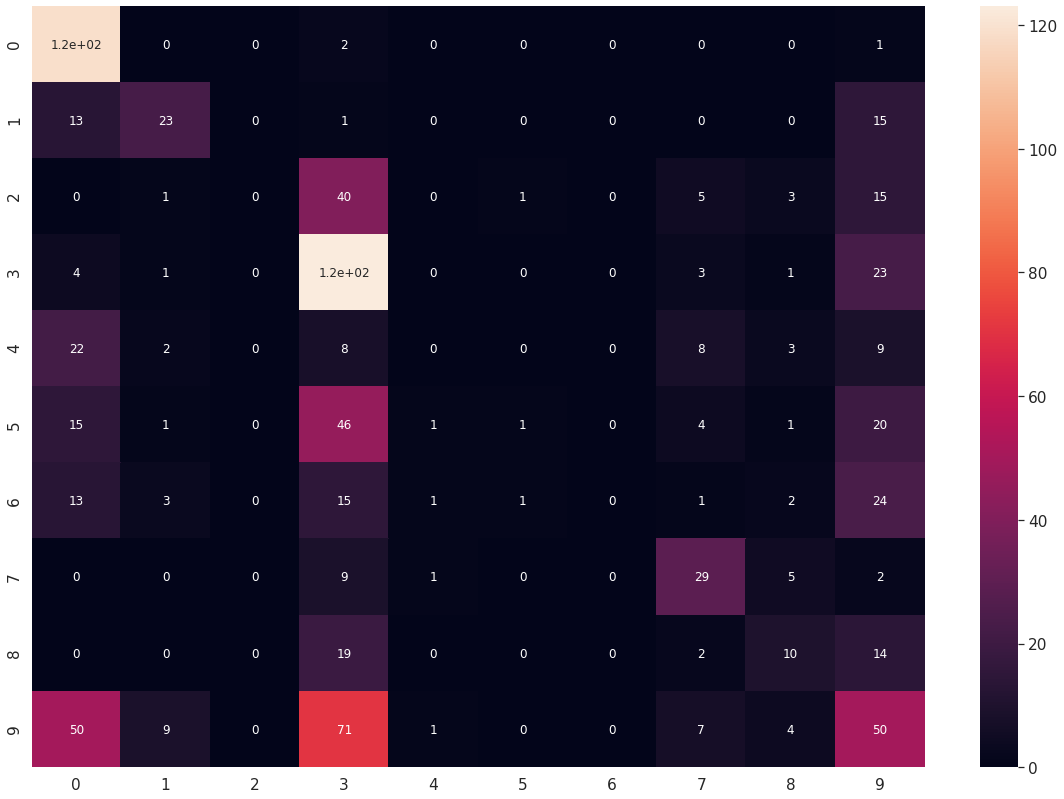

In [195]:
conf_matrix(num_classes, vgg16_predicted)

In [196]:
vgg16_report = classification_report(np.argmax(y_test, axis=1), vgg16_predicted)  
print(vgg16_report)

              precision    recall  f1-score   support

           0       0.50      0.98      0.66       122
           1       0.57      0.44      0.50        52
           2       0.00      0.00      0.00        65
           3       0.37      0.79      0.50       155
           4       0.00      0.00      0.00        52
           5       0.33      0.01      0.02        89
           6       0.00      0.00      0.00        60
           7       0.49      0.63      0.55        46
           8       0.34      0.22      0.27        45
           9       0.29      0.26      0.27       192

    accuracy                           0.40       878
   macro avg       0.29      0.33      0.28       878
weighted avg       0.31      0.40      0.32       878



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


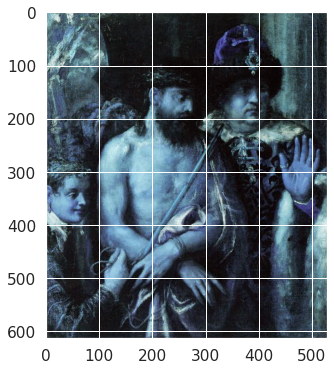

class for image 1: 2
predicted:         9


In [197]:
imgplot = plt.imshow(x_train_original[0])  
plt.show()  
print('class for image 1: ' + str(np.argmax(y_test[0])))  
print('predicted:         ' + str(vgg16_predicted[0]))  

In [198]:
#Histórico
with open('vgg16_history.txt', 'wb') as file_pi:  
    pickle.dump(vgg16.history, file_pi)

# ResNet

In [179]:
def CustomResNet50(include_top=True, input_tensor=None, input_shape=x_train[0].shape, pooling=None, classes=num_classes):  
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D(padding=(2, 2), name='conv1_pad')(img_input)

    x = resnet50.conv_block(x, 3, [32, 32, 64], stage=2, block='a')
    x = resnet50.identity_block(x, 3, [32, 32, 64], stage=2, block='b')
    x = resnet50.identity_block(x, 3, [32, 32, 64], stage=2, block='c')

    x = resnet50.conv_block(x, 3, [64, 64, 256], stage=3, block='a', strides=(1, 1))
    x = resnet50.identity_block(x, 3, [64, 64, 256], stage=3, block='b')
    x = resnet50.identity_block(x, 3, [64, 64, 256], stage=3, block='c')

    x = resnet50.conv_block(x, 3, [128, 128, 512], stage=4, block='a')
    x = resnet50.identity_block(x, 3, [128, 128, 512], stage=4, block='b')
    x = resnet50.identity_block(x, 3, [128, 128, 512], stage=4, block='c')
    x = resnet50.identity_block(x, 3, [128, 128, 512], stage=4, block='d')

    x = resnet50.conv_block(x, 3, [256, 256, 1024], stage=5, block='a')
    x = resnet50.identity_block(x, 3, [256, 256, 1024], stage=5, block='b')
    x = resnet50.identity_block(x, 3, [256, 256, 1024], stage=5, block='c')
    x = resnet50.identity_block(x, 3, [256, 256, 1024], stage=5, block='d')
    x = resnet50.identity_block(x, 3, [256, 256, 1024], stage=5, block='e')
    x = resnet50.identity_block(x, 3, [256, 256, 1024], stage=5, block='f')

    x = resnet50.conv_block(x, 3, [512, 512, 2048], stage=6, block='a')
    x = resnet50.identity_block(x, 3, [512, 512, 2048], stage=6, block='b')
    x = resnet50.identity_block(x, 3, [512, 512, 2048], stage=6, block='c')

    x = AveragePooling2D((1, 1), name='avg_pool')(x)

    if include_top:
        x = Flatten()(x)
        x = Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    return model

In [180]:
def create_custom_resnet50():  
  model = CustomResNet50(include_top=True, input_tensor=None, input_shape=x_train[0].shape, pooling=None, classes=num_classes)

  return model

custom_resnet50_model = create_custom_resnet50()  
custom_resnet50_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])  

NameError: name 'Input' is not defined

In [ ]:
crn50 = custom_resnet50_model.fit(x=x_train, y=y_train, batch_size=32, epochs=10, verbose=1, validation_data=(x_test, y_test), shuffle=True)

In [ ]:
plot_train_vs_test(crn50)

In [ ]:
crn50_pred = custom_resnet50_model.predict(x_test, batch_size=32, verbose=1)  
crn50_predicted = np.argmax(crn50_pred, axis=1)

In [ ]:
conf_matrix(num_classes, crn50_predicted)

In [ ]:
crn50_report = classification_report(np.argmax(y_test, axis=1), crn50_predicted)  
print(crn50_report)

# DenseNet121

In [90]:
def build_model():  
    base_model = densenet.DenseNet121(input_shape=(img_width, img_height, 3),
                                     include_top=False,
                                     pooling='avg')

    x = base_model.output
    x = Dense(1000, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    x = Dense(500, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    return model


In [91]:
model = build_model()  
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])  

NameError: name 'img_width' is not defined

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)  
callbacks_list = [early_stop, reduce_lr] 

In [ ]:
model_history = model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=callbacks_list)

# ImageNet

En este caso usaremos la red pre-entrenada *IncepcionResNetV2* con  *ImageNet*. Intentaremos ajustarla para ver que resultados nos da con nuestro dataset. Usaremos métodos de *fine-tuning* para ahorrar en nuestros recursos de computación y evitarnos la mayor parte del tiempo de entreno.

In [170]:
imagenet_model = InceptionResNetV2(weights='imagenet', include_top=False)

In [171]:
x = imagenet_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x) 
imagenet_model = Model(input=imagenet_model.input, output=predictions)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


In [172]:
LAYERS_TO_FREEZE=750

In [173]:
for layer in imagenet_model.layers[:LAYERS_TO_FREEZE]:
    layer.trainable = False

In [174]:
imagenet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])

In [175]:
#imagenet_model.summary()

In [176]:
imagenet_model.fit(x_train, y_train, batch_size=32, epochs=4, verbose=1, validation_split=0.2)

Train on 2808 samples, validate on 702 samples
Epoch 1/4
2808/2808 [==============================] - 342s 122ms/step - loss: 1.2626 - acc: 0.5755 - mse: 0.0558 - val_loss: 7268.6171 - val_acc: 0.0556 - val_mse: 0.1889
Epoch 2/4
2688/2808 [===========================>..] - ETA: 10s - loss: 0.5262 - acc: 0.8136 - mse: 0.0261

KeyboardInterrupt: 

In [83]:
imagenet_pred = model.predict(x_test, batch_size=32, verbose=1)  
imagenet_predicted = np.argmax(imagenet_pred, axis=1)  

878/878 [==============================] - 64s 73ms/step


In [ ]:
plot_train_vs_test(imagenet_model)

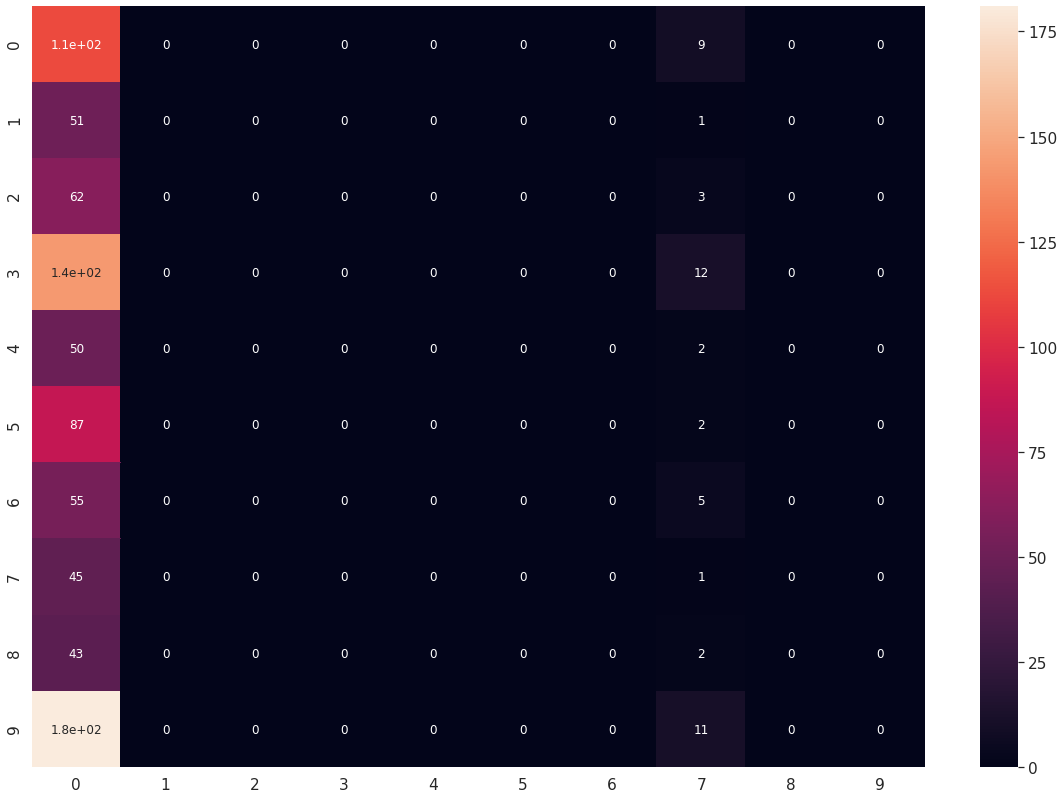

In [87]:
conf_matrix (num_classes, imagenet_predicted)

In [88]:
imagenet_report = classification_report(np.argmax(y_test, axis=1), imagenet_predicted)  
print(imagenet_report)

              precision    recall  f1-score   support

           0       0.14      0.93      0.24       122
           1       0.00      0.00      0.00        52
           2       0.00      0.00      0.00        65
           3       0.00      0.00      0.00       155
           4       0.00      0.00      0.00        52
           5       0.00      0.00      0.00        89
           6       0.00      0.00      0.00        60
           7       0.02      0.02      0.02        46
           8       0.00      0.00      0.00        45
           9       0.00      0.00      0.00       192

    accuracy                           0.13       878
   macro avg       0.02      0.09      0.03       878
weighted avg       0.02      0.13      0.03       878



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Modelo
imagenet_model.save('imagenet.h5')

#Histórico
with open('imagenet_history.txt', 'wb') as file_pi:  
  pickle.dump(imagenet.history, file_pi)

# NASNet

La arquitectura NASNet se compone de dos tipos de capas: La capa normal , y la capa de reducción. Ambas capas fueron diseñadas por AutoML.

In [125]:
def create_nasnet():  
  model = nasnet.NASNetMobile(input_shape=x_train[0].shape, include_top=True, weights=None, input_tensor=None, pooling=None, classes=num_classes)

  return model

In [126]:
nasnet_model = create_nasnet()  
nasnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse']) 

In [ ]:
nasnet_model.summary()  

In [ ]:
nasnet = nasnet_model.fit(x=x_train, y=y_train, batch_size=32, epochs=10, verbose=1, validation_data=(x_test, y_test), shuffle=True) 

Train on 3510 samples, validate on 878 samples
Epoch 1/10


In [ ]:
nasnet_pred = nasnet_model.predict(x_test, batch_size=32, verbose=1)  
nasnet_predicted = np.argmax(nasnet_pred, axis=1)

conf_matrix(num_classes, nasnet_predicted) 

In [ ]:
nasnet_report = classification_report(np.argmax(y_test, axis=1), nasnet_predicted)  
print(nasnet_report)

In [ ]:
#Modelo
nasnet_model.save('nasnet.h5')

#Histórico
with open('nasnet_history.txt', 'wb') as file_pi:  
  pickle.dump(nasnet.history, file_pi)

# Comparativa

In [ ]:
with open(path_base + '/simplenn_history.txt', 'rb') as f:  
  snn_history = pickle.load(f)

In [ ]:
with open(path_base + '/scnn_history.txt', 'wb') as file_pi:  
  pickle.dump(scnn.history, file_pi)

In [ ]:
with open(path_base + '/vgg16_history.txt', 'rb') as f:  
  vgg16_history = pickle.load(f)

In [ ]:
plt.figure(0)  
plt.plot(snn_history['val_acc'],'r')  
plt.plot(scnn_history['val_acc'],'g')  
plt.plot(vgg16_history['val_acc'],'b')  
plt.plot(vgg19.history['val_acc'],'y')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Simple NN Accuracy vs simple CNN Accuracy")  
plt.legend(['simple NN','CNN','VGG 16'])  

In [ ]:
plt.figure(0)  
plt.plot(snn_history['val_loss'],'r')  
plt.plot(scnn.history['val_loss'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Simple NN Loss vs simple CNN Loss")  
plt.legend(['simple NN','CNN', 'VGG 16'])

In [ ]:
plt.figure(0)  
plt.plot(snn_history['val_mean_squared_error'],'r')  
plt.plot(scnn.history['val_mean_squared_error'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Mean Squared Error")  
plt.title("Simple NN MSE vs simple CNN MSE")  
plt.legend(['simple NN','CNN', 'VGG 16'])  